In [1]:
import tensorflow as tf
import numpy as np

In [2]:
class ConvolutionNetwork:
    
    def __init__(self, n_kernels=10, units=10, batch_size=32, learning_rate=0.1):
        self.n_kernels = n_kernels
        self.kernel_size = 3
        self.optimizer = None
        self.conv_w = None
        self.conv_b = None
        self.units = units
        self.batch_size = batch_size
        self.w1 = None
        self.b1 = None
        self.w2 = None
        self.b2 = None
        self.a1 = None
        self.losses = []
        self.val_losses = []
        self.lr = learning_rate
        
    def forpass(self, x):
        c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding="SAME") + self.conv_b
        
        r_out = tf.nn.relu(c_out)
        
        p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding="VALID")
        
        f_out = tf.reshape(p_out, [x.shape[0], -1])
        
        z1 = tf.matmul(f_out, self.w1) + self.b1
        
        a1 = tf.nn.relu(z1)
        
        z2 = tf.matmul(a1, self.w2) + self.b2
        return z2
    
    def init_weights(self, input_shape, n_classes):
        g = tf.initializers.glorot_uniform()
        
        self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels)))
        
        self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float)
        
        n_features = 14 * 14 * self.n_kernels
        
        self.w1 = tf.Variable(g((n_features, self.units)))
        
        self.b1 = tf.Variable(np.zeros(self.units), dtype=float)
        
        self.w2 = tf.Variable(g((self.units, n_classes)))
        
        self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)
    
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.init_weights(x.shape, y.shape[1])
        
        self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
        
        for i in range(epochs):
            print("epochs", i, end=" ")
            
            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x,y):
                print(".", end="")
                self.training(x_batch, y_batch)
                
                batch_losses.append(self.get_loss(x_batch, y_batch))
            print( )
            
            self.losses.append(np.mean(batch_losses))
            
            self.val_losses.append(self.get_loss(x_val, y_val))
    
    def gen_batch(self, x, y):
        
        bins = len(x) // self.batch_size
        indexes = np.random.permutation(np.arange(len(x)))
        x = x[indexes]
        y = y[indexes]
        
        for i in range(bins):
            
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            
            yield x[start:end], y[start:end]
    
    def training(self, x, y):
        
        m = len(x)
        
        with tf.GradientTape() as tape:
            z = self.forpass(x)
            loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
            loss = tf.reduce_mean(loss)
        weights_list = [self.conv_w, self.conv_b, self.w1, self.b1, self.w2, self.b2]
        
        grads = tape.gradient(loss, weights_list)
        
        self.optimizer.apply_gradients(zip(grads, weights_list))
        
    def predict(self, x):
        
        z = self.forpass(x)
        return np.argmax(z.numpy(), axis=1)
    
    def score(self, x, y):
        return np.mean(self.predict(x) == np.argmax(y, axis=1))
    
    def get_loss(self, x, y):
        
        z = self.forpass(x)
        
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
        
        return loss.numpy()

In [3]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [5]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [6]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

In [7]:
x_train.shape

(48000, 28, 28, 1)

In [8]:
x_train = x_train / 255
x_val = x_val / 255

In [9]:
cn = ConvolutionNetwork(n_kernels=10, units=100, batch_size=128, learning_rate=0.01)

In [10]:
cn.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=20)

epochs 0 .......................................................................................................................................................................................................................................................................................................................................................................................
epochs 1 .......................................................................................................................................................................................................................................................................................................................................................................................
epochs 2 .............................................................................................................................................................................................................................

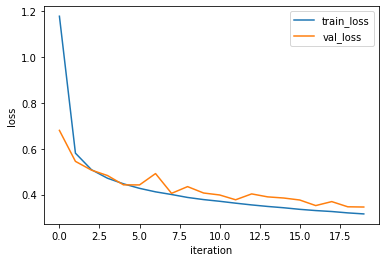

In [11]:
import matplotlib.pyplot as plt

plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel("loss")
plt.xlabel("iteration")
plt.legend(["train_loss", "val_loss"])
plt.show()

In [12]:
cn.score(x_val, y_val_encoded)

0.88125

In [13]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

conv1 = tf.keras.Sequential()
conv1.add(Conv2D(10, (3,3), activation="relu", padding="same", input_shape=(28,28, 1)))
conv1.add(MaxPooling2D((2,2)))
conv1.add(Flatten())
conv1.add(Dense(100, activation="relu"))
conv1.add(Dense(10, activation="softmax"))

In [14]:
conv1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1960)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               196100    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
_________________________________________________________________


In [15]:
conv1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [16]:
history = conv1.fit(x_train, y_train_encoded, epochs=20, validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 9s 4ms/step - loss: 0.4373 - accuracy: 0.8456 - val_loss: 0.3259 - val_accuracy: 0.8824
Epoch 2/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3054 - accuracy: 0.8892 - val_loss: 0.3015 - val_accuracy: 0.8940
Epoch 3/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2616 - accuracy: 0.9038 - val_loss: 0.2775 - val_accuracy: 0.8989
Epoch 4/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2319 - accuracy: 0.9149 - val_loss: 0.2533 - val_accuracy: 0.9100
Epoch 5/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2062 - accuracy: 0.9233 - val_loss: 0.2508 - val_accuracy: 0.9128
Epoch 6/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1848 - accuracy: 0.9315 - val_loss: 0.2573 - val_accuracy: 0.9082
Epoch 7/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1679 - accuracy: 0.9374 - val_loss: 0.2412 - val_accuracy:

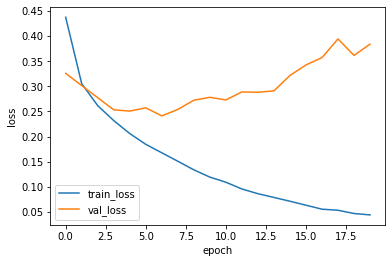

In [17]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss", "val_loss"])
plt.show()

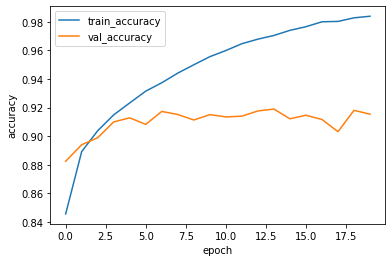

In [18]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train_accuracy", "val_accuracy"])
plt.show()

In [19]:
conv2 = tf.keras.Sequential()
conv2.add(Conv2D(10, (3,3), activation="relu", padding="same", input_shape=(28,28, 1)))
conv2.add(MaxPooling2D((2,2)))
conv2.add(Flatten())
conv2.add(Dropout(0.5))
conv2.add(Dense(100, activation="relu"))
conv2.add(Dense(10, activation="softmax"))

In [20]:
conv2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1960)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               196100    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
________________________________________________

In [21]:
conv2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [22]:
history2 = conv2.fit(x_train, y_train_encoded, epochs=20, validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 7s 4ms/step - loss: 0.5343 - accuracy: 0.8067 - val_loss: 0.3710 - val_accuracy: 0.8716
Epoch 2/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3896 - accuracy: 0.8588 - val_loss: 0.3197 - val_accuracy: 0.8856
Epoch 3/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3418 - accuracy: 0.8762 - val_loss: 0.2925 - val_accuracy: 0.8948
Epoch 4/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3141 - accuracy: 0.8843 - val_loss: 0.2708 - val_accuracy: 0.9030
Epoch 5/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2901 - accuracy: 0.8927 - val_loss: 0.2553 - val_accuracy: 0.9084
Epoch 6/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2727 - accuracy: 0.8990 - val_loss: 0.2656 - val_accuracy: 0.9023
Epoch 7/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2599 - accuracy: 0.9052 - val_loss: 0.2474 - val_accuracy:

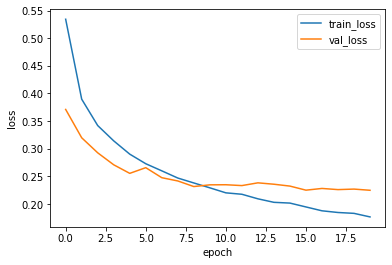

In [23]:
plt.plot(history2.history["loss"])
plt.plot(history2.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss", "val_loss"])
plt.show()

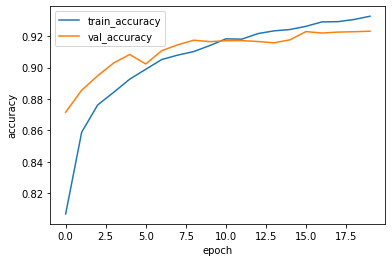

In [24]:
plt.plot(history2.history["accuracy"])
plt.plot(history2.history["val_accuracy"])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train_accuracy", "val_accuracy"])
plt.show()